In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , BatchNormalization , Lambda , Activation , Dropout

import matplotlib.pyplot as plt

In [2]:
TARGET_X = 256
TARGET_Y = 256
BATCH_SIZE = 32
CLASS_NUM = 50
EPOCH = 15

In [3]:
def append_ext(fn):
    return fn+".png"

train_classes=pd.read_csv('./multiclass.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].str.split(' ')
train_classes["id"]=train_classes["id"].apply(append_ext)


print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1000fe2e667721fe.png          [51]
1  10041eb49b297c08.png          [51]
2  100501c227f8beea.png          [13]
3  1008abd71f3ed5bc.png          [70]
4  100a0dcde728cb36.png          [51]


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='../data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='../data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

Found 17670 validated image filenames belonging to 50 classes.
Found 4417 validated image filenames belonging to 50 classes.


In [5]:
model = Sequential()

model.add(Conv2D(96, 7, strides=3, padding='same', input_shape=(TARGET_X,TARGET_Y,3)))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Conv2D(256, 5, strides=3, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Dropout(0.5))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 96)        14208     
_________________________________________________________________
lambda (Lambda)              (None, 86, 86, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 86, 86, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 256)       0

In [6]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy",  "Precision", "Recall", "AUC",tf.keras.metrics.TopKCategoricalAccuracy()])

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCH,
                    verbose=1)

C:\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/15
552/552 [==============================] - 395s 686ms/step - loss: 2.0764 - accuracy: 0.3930 - precision: 0.4027 - recall: 0.0689 - auc: 0.9198 - top_k_categorical_accuracy: 0.7952 - val_loss: 1.8038 - val_accuracy: 0.4171 - val_precision: 0.7497 - val_recall: 0.1316 - val_auc: 0.9424 - val_top_k_categorical_accuracy: 0.8400
Epoch 2/15
552/552 [==============================] - 432s 783ms/step - loss: 1.7723 - accuracy: 0.4288 - precision: 0.5831 - recall: 0.1429 - auc: 0.9436 - top_k_categorical_accuracy: 0.8415 - val_loss: 1.6266 - val_accuracy: 0.5315 - val_precision: 0.6441 - val_recall: 0.3143 - val_auc: 0.9561 - val_top_k_categorical_accuracy: 0.8486
Epoch 3/15
552/552 [==============================] - 293s 531ms/step - loss: 1.5868 - accuracy: 0.5338 - precision: 0.6401 - recall: 0.3

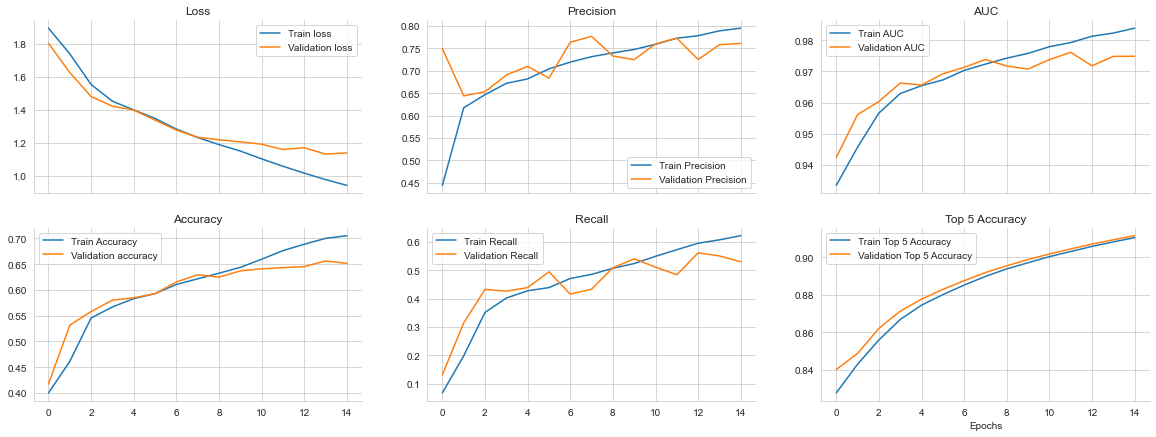

In [7]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 3, sharex='col', figsize=(20,7))

axs[0,0].plot(history.history['loss'], label='Train loss')
axs[0,0].plot(history.history['val_loss'], label='Validation loss')
axs[0,0].legend(loc='best')
axs[0,0].set_title('Loss')

axs[1,0].plot(history.history['accuracy'], label='Train Accuracy')
axs[1,0].plot(history.history['val_accuracy'], label='Validation accuracy')
axs[1,0].legend(loc='best')
axs[1,0].set_title('Accuracy')

axs[0,1].plot(history.history['precision'], label='Train Precision')
axs[0,1].plot(history.history['val_precision'], label='Validation Precision')
axs[0,1].legend(loc='best')
axs[0,1].set_title('Precision')

axs[1,1].plot(history.history['recall'], label='Train Recall')
axs[1,1].plot(history.history['val_recall'], label='Validation Recall')
axs[1,1].legend(loc='best')
axs[1,1].set_title('Recall')

axs[0,2].plot(history.history['auc'], label='Train AUC')
axs[0,2].plot(history.history['val_auc'], label='Validation AUC')
axs[0,2].legend(loc='best')
axs[0,2].set_title('AUC')

axs[1,2].plot(history.history['top_k_categorical_accuracy'], label='Train Top 5 Accuracy')
axs[1,2].plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top 5 Accuracy')
axs[1,2].legend(loc='best')
axs[1,2].set_title('Top 5 Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()